# Homework

## Task 1

Design your on own CNN network and aim for the best in CIFAR-10 classification! 

Try to make your model perform well using the techniques we've discussed before, but don't be too harsh on yourself :）

Your steps should be:

- Load Dataset
- Model Architecture Design
- Model Training Loop
- Testing on CIFAR-10


### Step 1: Load Dataset

In [60]:
# your code here
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# # 设置 matplotlib 显示格式
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
# plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transforms(sample)
        
        # 确保返回的是 PyTorch 张量
        if not isinstance(sample, torch.Tensor):
            sample = torch.tensor(sample, dtype=torch.float32)
        else:
            sample = sample.to(dtype=torch.float32)

        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)
        else:
            label = label.to(dtype=torch.long)

        return sample, label
    
        
transform = transforms.Compose(
    [transforms.ToTensor(),  # [0, 255], PIL Image / ndarray --> [0, 1], torch.tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化, (input[channel] - mean[channel]) / std[channel]
)
traindata = trainset.data
trainlabels = trainset.targets
testdata = testset.data
testlabels = testset.targets

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, transform)
testset = OursDatasetwithTransforms(testdata, testlabels, transform)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
len(trainset), len(testset)

(50000, 10000)

### Step 2: Model Architecture Design

In [62]:
# your code here
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 卷积层 & 池化层
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )  # 3*32*32 -> 32*32*32
        self.bn1 = nn.BatchNorm2d(num_features=32)  # 批标准化
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32*32*32 -> 32*16*16
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1
        )  # 32*16*16 -> 64*16*16
        self.bn2 = nn.BatchNorm2d(num_features=64)  # 批标准化
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64*16*16 -> 64*8*8

        # 全连接层
        self.fc3 = nn.Linear(in_features=64 * 8 * 8, out_features=256)  # 展平 -> 256
        self.fc4 = nn.Linear(in_features=256, out_features=10)  # 256 -> 10

        # dropout
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x):
        # 卷积 + batchnorm + relu + 池化
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # 全连接 + relu + dropout
        x = x.view(-1, 64 * 8 * 8)  # 展平
        x = F.relu(self.fc3(x))
        x = self.drop(x)
        x = self.fc4(x)

        return x

### Step 3: Model Training Loop

In [63]:
# your code here
def training_loop(model, trainloader, testloader, optimizer, loss_fn, n_epoch, device):
    # 记录训练过程中训练集和测试集上的损失变化
    train_loss_history = []
    test_loss_history = []

    # 循环训练
    model.train()
    for epoch in range(n_epoch):
        total_loss = 0

        # 遍历训练数据
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            probs = model(images)  # 前向传播
            loss = loss_fn(probs, labels)  # 计算损失
            total_loss += loss.item()
            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数

        avg_train_loss = total_loss / len(trainloader)
        avg_test_loss, test_accuracy = test(model, testloader, loss_fn, device)
        print(
            f"Epoch[{epoch+1}], Train Loss: {avg_train_loss:.4f},",
            f"Test Loss: {avg_test_loss:.4f},"
            f"Test Accuracy: {(test_accuracy * 100):.2f}%",
        )

        train_loss_history.append(avg_train_loss)
        test_loss_history.append(avg_test_loss)

    # 可视化训练损失和测试损失
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Train and Test Loss")
    plt.show()


def test(model, testloader, loss_fn, device):
    # 记录测试过程中的损失和正确数量
    total_loss = 0
    correct_count = 0
    total_count = 0

    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            probs = model(images)  # 模型输出的标签概率分布
            _, predictions = probs.max(dim=1)  # 取最大概率的为预测标签
            loss = loss_fn(probs, labels)  # 计算损失
            total_loss += loss.item()
            correct_count += predictions.eq(labels).sum().item()  # 记录正确的数量
            total_count += labels.shape[0]  # 记录这一批样本的数量

    avg_test_loss = total_loss / len(testloader)
    test_accuracy = correct_count / total_count

    return avg_test_loss, test_accuracy

Epoch[1], Train Loss: 1.5657, Test Loss: 1.1677,Test Accuracy: 57.99%
Epoch[2], Train Loss: 1.0220, Test Loss: 0.9381,Test Accuracy: 66.76%
Epoch[3], Train Loss: 0.8415, Test Loss: 0.8505,Test Accuracy: 70.10%
Epoch[4], Train Loss: 0.7252, Test Loss: 0.8171,Test Accuracy: 71.73%
Epoch[5], Train Loss: 0.6319, Test Loss: 0.8200,Test Accuracy: 72.22%
Epoch[6], Train Loss: 0.5431, Test Loss: 0.8557,Test Accuracy: 71.98%
Epoch[7], Train Loss: 0.4672, Test Loss: 0.8429,Test Accuracy: 72.93%
Epoch[8], Train Loss: 0.3899, Test Loss: 0.8358,Test Accuracy: 73.94%
Epoch[9], Train Loss: 0.3186, Test Loss: 0.9428,Test Accuracy: 72.68%
Epoch[10], Train Loss: 0.2582, Test Loss: 0.9861,Test Accuracy: 73.45%
Epoch[11], Train Loss: 0.2045, Test Loss: 1.0948,Test Accuracy: 72.32%
Epoch[12], Train Loss: 0.1562, Test Loss: 1.2375,Test Accuracy: 71.79%
Epoch[13], Train Loss: 0.1257, Test Loss: 1.2684,Test Accuracy: 71.40%
Epoch[14], Train Loss: 0.1100, Test Loss: 1.3928,Test Accuracy: 71.79%
Epoch[15], Trai

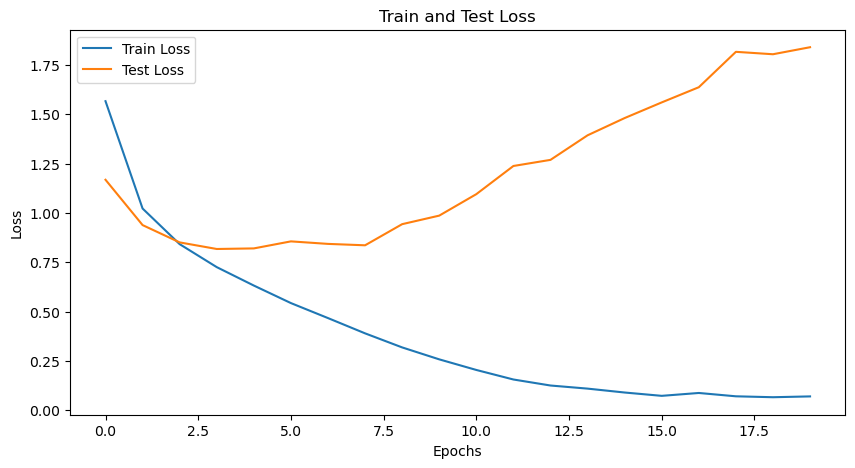

In [64]:
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(my_device)
# trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=False)
# testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)

training_loop(
    model=model,
    trainloader=DataLoader(trainset, batch_size=256, shuffle=True, drop_last=False),
    testloader=DataLoader(testset, batch_size=1024, shuffle=False, drop_last=False),
    optimizer=optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    loss_fn=nn.CrossEntropyLoss(),
    n_epoch=20,
    device=my_device,
)

### Step 4: Testing on CIFAR-10

In [ ]:
# your code here


## Task 2

After designing your own model，use at least one of the powerful models (AlexNet, VGG, Resnet, etc.) to train on CIFAR-10 to see how well it performs. (Or try more than one if you have time)

In [30]:
# you can load the pretrained models like this
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)
alexnet = models.alexnet(pretrained=True)
resnet50 = models.resnet50(pretrained=True)

d:\Envs\Anaconda3\envs\gpuPytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Envs\Anaconda3\envs\gpuPytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\charles0618/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [01:58<00:00, 4.69MB/s] 
d:\Envs\Anaconda3\envs\gpuPytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are dep

URLError: <urlopen error TLS/SSL connection has been closed (EOF) (_ssl.c:1133)>